In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

#Tensorflow
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,save_model,load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.metrics import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import keras

%matplotlib inline

2024-08-08 19:30:22.626911: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-08 19:30:22.655654: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-08 19:30:22.666095: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-08 19:30:22.682171: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-08 19:30:22.687085: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-08 19:30:22.706057: I tensorflow/core/platform/cpu_feature_gu

In [2]:
xls = pd.ExcelFile("Precios-Promedio-Nacionales-Diarios-2024-3.xlsx")

prices_data_2024 = pd.read_excel(xls, sheet_name="2024", index_col=[0], header=[0,1], skiprows=7, skipfooter=3)
prices_data_2024.columns = prices_data_2024.columns.map(' '.join)
prices_data_2024.rename_axis("Fecha").reset_index()

prices_data_2023 = pd.read_excel(xls, sheet_name="2023", index_col=[0], header=[0,1], skiprows=7, skipfooter=3)
prices_data_2023.columns = prices_data_2024.columns
prices_data_2023.rename_axis("Fecha").reset_index()

prices_data_2022 = pd.read_excel(xls, sheet_name="2022", index_col=[0], header=[0,1], skiprows=6, skipfooter=3)
prices_data_2022.columns = prices_data_2023.columns
prices_data_2022.rename_axis("Fecha").reset_index()

prices_data_2021 = pd.read_excel(xls, sheet_name="2021", index_col=[0], header=[0,1], skiprows=6, skipfooter=3)
prices_data_2021.columns = prices_data_2022.columns
prices_data_2021.rename_axis("Fecha").reset_index()

prices_data = pd.concat([prices_data_2021, prices_data_2022, prices_data_2023, prices_data_2024])
prices_data.drop(columns=["Tipo de Cambio GTQ/USD", "Bunker GTQ/GALON"], axis=1, inplace=True)

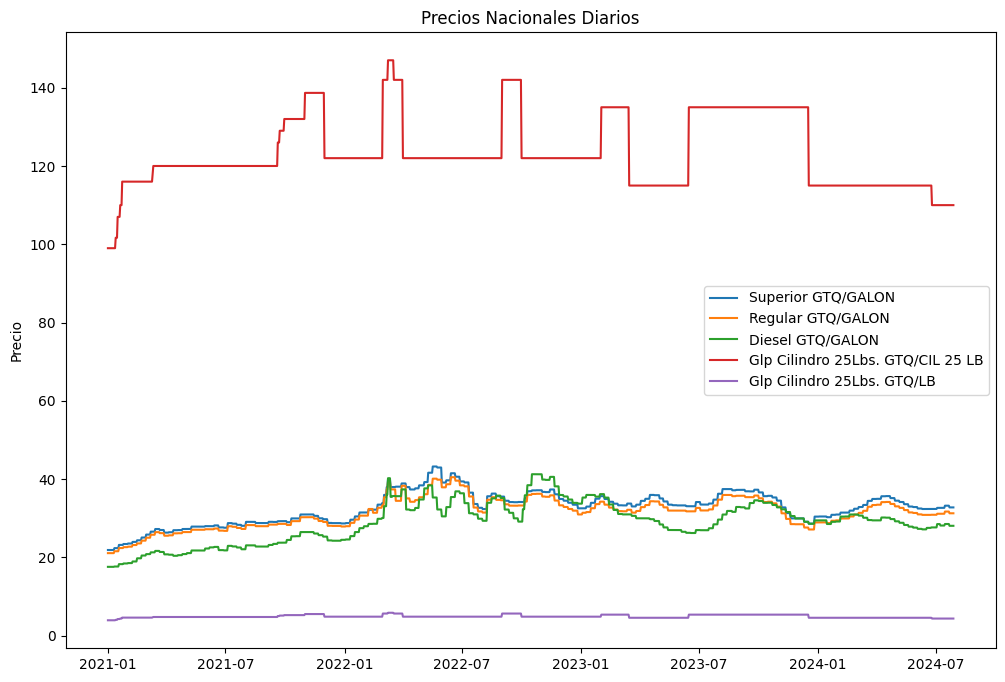

In [3]:
plt.figure(figsize=(12, 8))
for column in prices_data.columns:
    plt.plot(prices_data[column], label=f"{column}")

plt.ylabel("Precio")
plt.title(f'Precios Nacionales Diarios')
plt.legend()
plt.show()

/tmp/ipykernel_23639/135182886.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


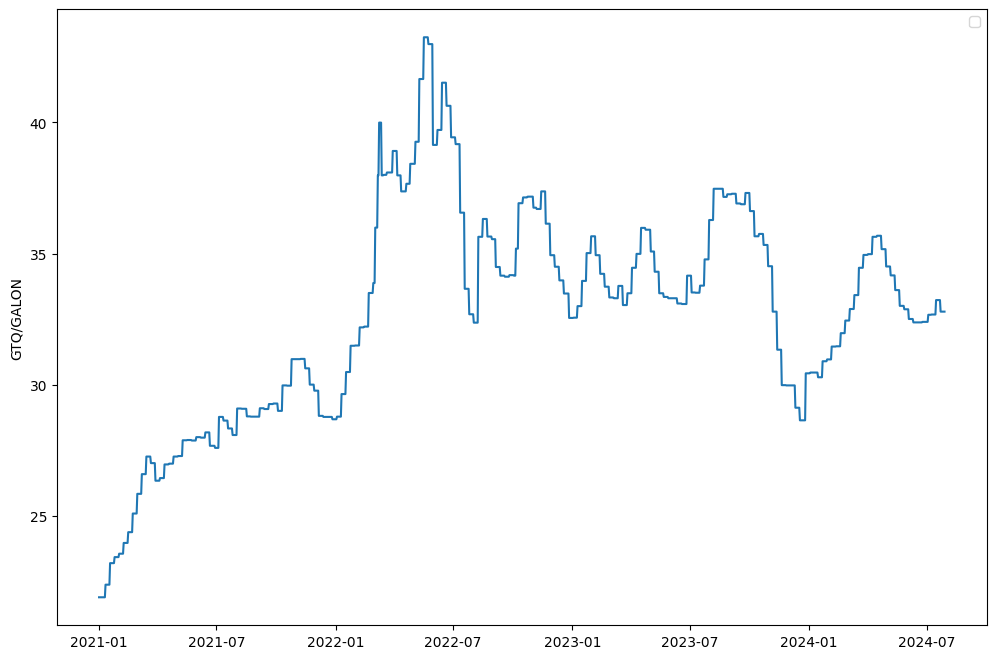

In [4]:
super_prices = prices_data["Superior GTQ/GALON"]
super_prices.dropna(inplace=True)

plt.figure(figsize=(12,8))
plt.plot(super_prices)
plt.ylabel('GTQ/GALON')
plt.legend()
plt.show()

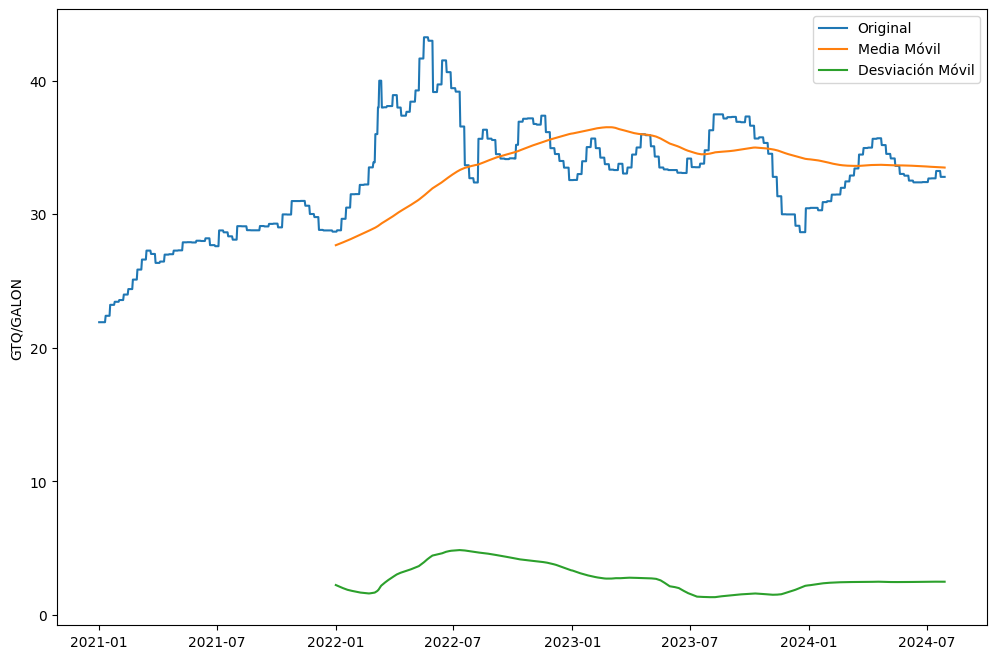

In [5]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 90 días.
mediaMovil = super_prices.rolling(window=365).mean()
deMovil = super_prices.rolling(window=365).std()


# Plot original data
plt.figure(figsize=(12, 8))
plt.plot(super_prices, label='Original')
plt.plot(mediaMovil, label='Media Móvil')
plt.plot(deMovil, label='Desviación Móvil')

plt.ylabel('GTQ/GALON')
plt.legend()
plt.show()

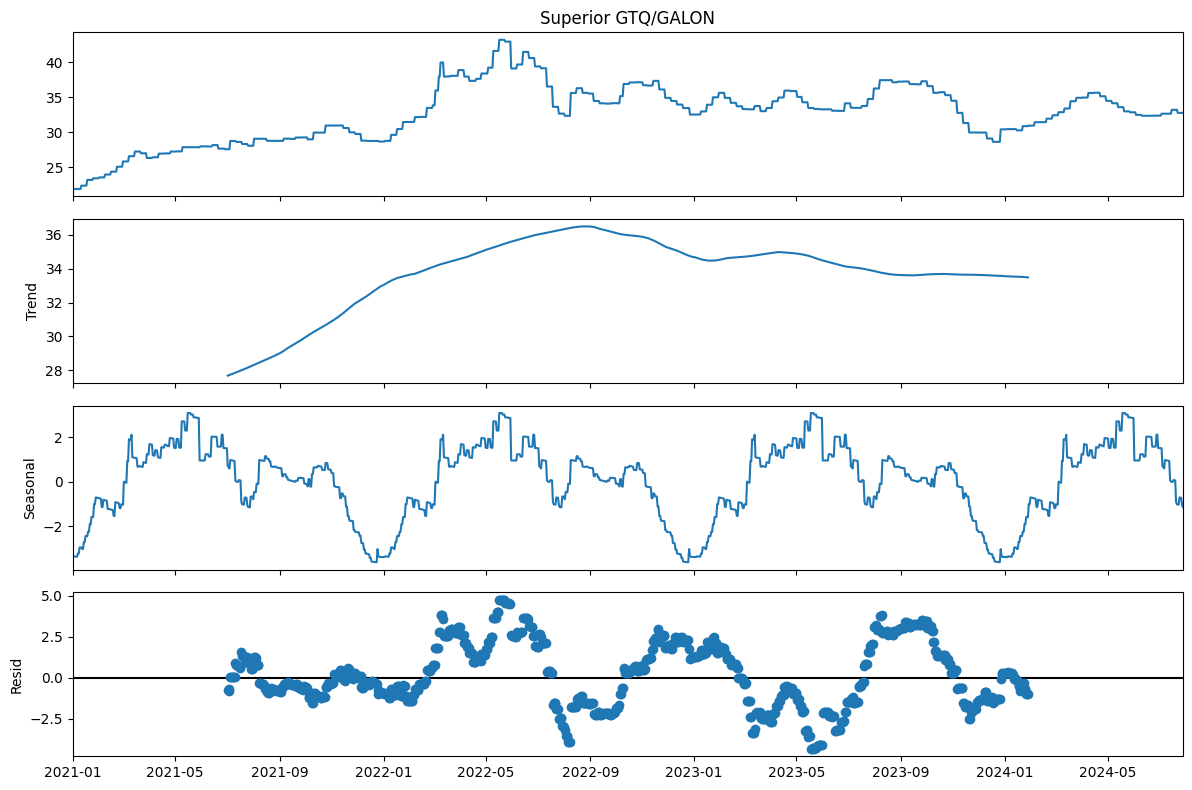

In [6]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(12, 8))
    descomposicion = seasonal_decompose(super_prices, period=365)
    descomposicion.plot()

In [7]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(super_prices, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          -2.938738
p-value                         0.041025
# de retardos usados            7.000000
# de observaciones usadas    1294.000000
Critical Value (1%)            -3.435414
Critical Value (5%)            -2.863776
Critical Value (10%)           -2.567961
dtype: float64


In [8]:
super_prices = super_prices.to_frame()
super_prices

,Superior GTQ/GALON
2021-01-01,21.91
2021-01-02,21.91
2021-01-03,21.91
2021-01-04,21.91
2021-01-05,21.91
...,...
2024-07-24,32.79
2024-07-25,32.79
2024-07-26,32.79
2024-07-27,32.79


In [9]:
scaler = StandardScaler()
super_prices_scaled = scaler.fit_transform(super_prices)
super_prices_scaled[:5]

array([[-2.60963471],
       [-2.60963471],
       [-2.60963471],
       [-2.60963471],
       [-2.60963471]])

In [10]:
train_count = super_prices[:"2023-12-30"]["Superior GTQ/GALON"].count()
val_count = test_count = int((super_prices["Superior GTQ/GALON"].count() - train_count) / 2)

print(train_count)
print(val_count)
print(test_count)

1092
105
105


In [11]:
train = super_prices_scaled[:train_count]
validation = super_prices_scaled[train_count:(train_count + val_count)]
test = super_prices_scaled[(train_count + val_count):]

train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

105

In [12]:
def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)

In [13]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

104

In [14]:
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada

inputs = keras.layers.Input((paso,caracteristicas))
lstm_out = keras.layers.LSTM(lote, activation="relu", kernel_regularizer=keras.regularizers.l1_l2(0.001))(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

modelo1 = keras.Model(inputs=inputs, outputs=outputs)
modelo1.summary()

2024-08-08 19:30:26.099901: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: localhost.localdomain
2024-08-08 19:30:26.099929: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: localhost.localdomain
2024-08-08 19:30:26.100043: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2024-08-08 19:30:26.100078: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] kernel reported version is: 550.100.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:

inputs = keras.layers.Input((paso,caracteristicas))
lstm_out = keras.layers.LSTM(lote, activation="tanh", kernel_regularizer=keras.regularizers.l1_l2(0.001))(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

modelo2 = keras.Model(inputs=inputs, outputs=outputs)
modelo2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
modelo1.compile(loss='mean_squared_error',optimizer="adam")
modelo2.compile(loss='mean_squared_error',optimizer="rmsprop")

In [17]:
epocas = 150
history1= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    #callbacks=[early_stop],
    verbose=1
)

Epoch 1/150
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 2s 790us/step - loss: 2.0815 - val_loss: 0.2197
Epoch 2/150
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/step - loss: 2.1361 - val_loss: 0.2261
Epoch 3/150
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step - loss: 2.1561 - val_loss: 0.2282
Epoch 4/150
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 1s 638us/step - loss: 2.1635 - val_loss: 0.2286
Epoch 5/150
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step - loss: 2.1659 - val_loss: 0.2286
Epoch 6/150
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 1s 624us/step - loss: 2.1666 - val_loss: 0.2285
Epoch 7/150
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - loss: 2.1668 - val_loss: 0.2284
Epoch 8/150
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step - loss: 2.1668 - val_loss: 0.2284
Epoch 9/150
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 1s 666us/step - loss: 2.1668 - val_loss: 0.2284
Epoch 10/150
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/step - loss: 2.1668 - val_loss: 0.2284
Epoch 11/150
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 1s 638us/step - loss: 2.1668 - val_loss: 0.22

In [18]:
history2= modelo2.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    #callbacks=[early_stop],
    verbose=1
)

Epoch 1/150


1092/1092 ━━━━━━━━━━━━━━━━━━━━ 2s 816us/step - loss: 1.8049 - val_loss: 0.0475
Epoch 2/150
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step - loss: 0.4738 - val_loss: 0.0048
Epoch 3/150
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 1s 756us/step - loss: 0.2949 - val_loss: 0.0063
Epoch 4/150
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 1s 654us/step - loss: 0.3103 - val_loss: 0.0065
Epoch 5/150
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/step - loss: 0.3170 - val_loss: 0.0061
Epoch 6/150
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 1s 585us/step - loss: 0.3055 - val_loss: 0.0058
Epoch 7/150
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step - loss: 0.2942 - val_loss: 0.0055
Epoch 8/150
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 1s 611us/step - loss: 0.2833 - val_loss: 0.0052
Epoch 9/150
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step - loss: 0.2732 - val_loss: 0.0050
Epoch 10/150
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 1s 588us/step - loss: 0.2636 - val_loss: 0.0048
Epoch 11/150
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 1s 594us/step - loss: 0.2544 - val_loss: 0.0046
Epoch 12/

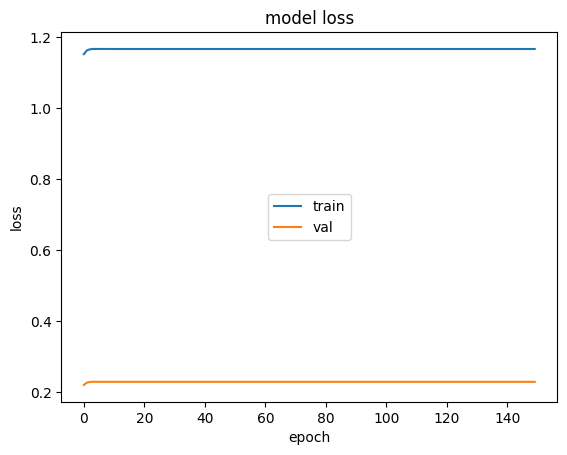

In [19]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

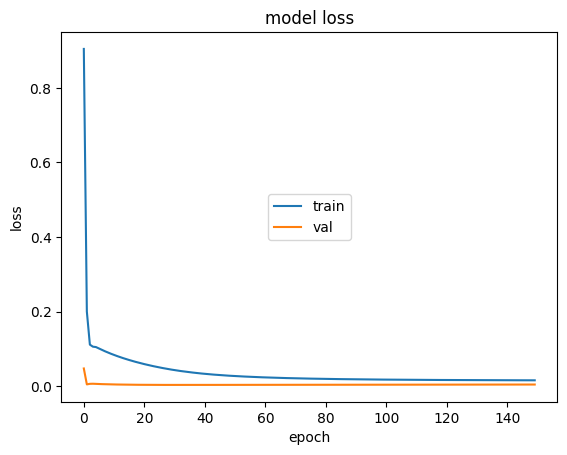

In [20]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

<Axes: >

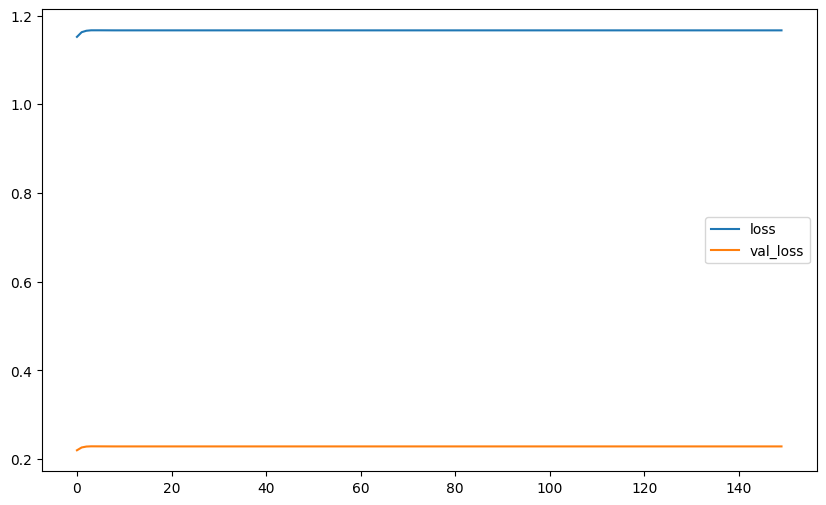

In [21]:
losses_df1 = pd.DataFrame(history1.history)

losses_df1.plot(figsize = (10,6))

<Axes: >

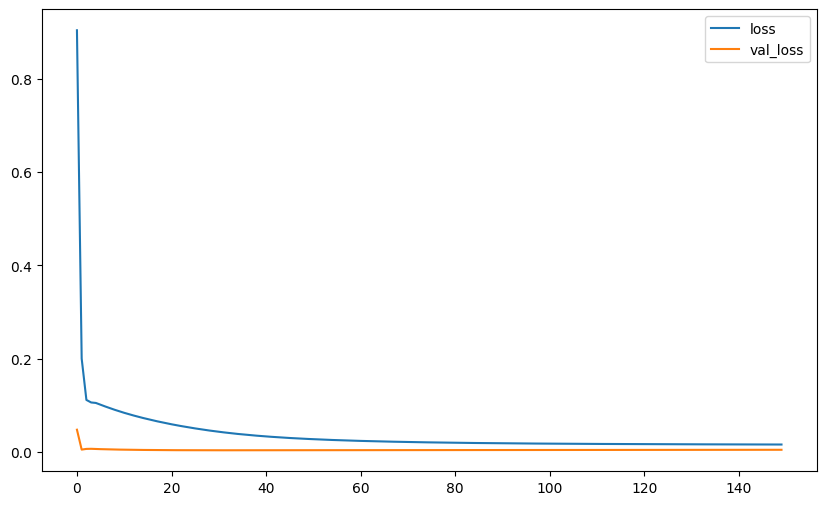

In [22]:
losses_df2 = pd.DataFrame(history2.history)

losses_df2.plot(figsize = (10,6))

In [23]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 2.2318
Pérdida en Validación
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2828 
Pérdida en Prueba
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 0.0797


0.0604124590754509

In [24]:
print("Pérdida en Entrenamiento")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 0.0592
Pérdida en Validación
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 0.0033
Pérdida en Prueba
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 0.0029


0.002671817084774375